In [208]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.optimize import minimize

In [233]:
start_date = '2018-01-01'
end_date = '2022-12-31'
stock = ["GOOGL", "ORCL", "MSFT"]
data = yf.download(stock, start_date, end_date)["Close"]

[*********************100%***********************]  3 of 3 completed


In [238]:
class Strategy():
    def __init__(self, data, lag):
        self.data = data
        self.lag = lag

        self.returns = self.data.pct_change()
        self.diff_data = self.data.diff()
        self.abs_diff_data = abs(self.diff_data)
        self.nominator_data =(self.diff_data+self.abs_diff_data)/2
        self.prob = self.nominator_data.rolling(self.lag).sum()/self.abs_diff_data.rolling(self.lag).sum()

        self.sig = 1*(self.prob>0.5)-1*(self.prob<0.5)
        
    def get_return(self):
        r = (self.sig*self.returns.shift(-1))
        return r
        
    def get_strategy_return(self):
        return np.prod(1+self.get_return())**(252/len(self.get_return()))-1

    def get_sharpe(self):
        r =self.get_return()
        try:
            return (self.get_strategy_return())/(np.std(r)*np.sqrt(252))
        except Exception:
            return 0
    def get_plot(self):
        r =self.get_return()
        plt.plot(np.cumprod(1+r), label=r.columns)
        # plt.plot(np.cumprod(1+self.data["return"]), label="buy and hold") 
        plt.title("Cumulative return") 
        plt.legend() 
        
class Portfolio(Strategy):
    def __init__(self, data, lag):
        super().__init__(data, lag)
        
    def optimize_portfolio(self, target_return=0.05):
        returns = self.get_return()
        n = returns.shape[1]
        initial_guess = np.ones(n)/n
        bounds = [(0, 1) for i in range(n)]
        constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
                    {'type': 'eq', 'fun': lambda x: np.dot(x, returns.mean()) - target_return})
        result = minimize(lambda x: -np.dot(x, returns.mean()) / np.sqrt(np.dot(x, np.dot(returns.cov(), x))),
                        initial_guess, bounds=bounds, constraints=constraints)
        return result.x
        
    def calc_profit_loss(self):
        pnl = np.dot(self.get_return(), self.optimize_portfolio())
        return np.cumprod(1+pnl)


In [239]:
m = Portfolio(data, 10)

In [240]:
m.get

array([1.66370823e-16, 9.42767999e-16, 1.00000000e+00])

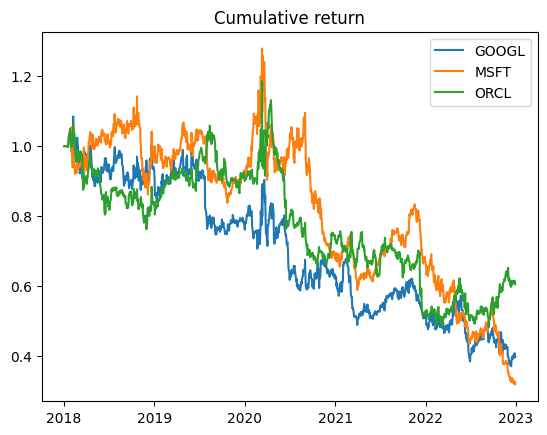

In [241]:
m.get_plot()

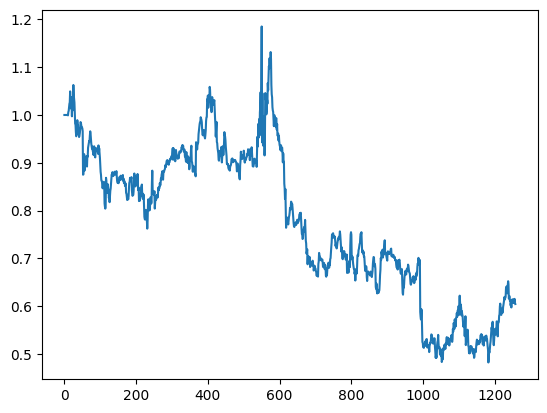

In [236]:
plt.plot(m.calc_profit_loss())